# 임포트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 구글 드라이브 연결

Mounted at /content/drive


In [ ]:
import pandas as pd
X_train_enn = pd.read_csv('/content/drive/My Drive/X_train_enn.csv')
y_train_enn = pd.read_csv('/content/drive/My Drive/y_train_enn.csv')
X_test = pd.read_csv('/content/drive/My Drive/X_test.csv')
y_test = pd.read_csv('/content/drive/My Drive/y_test.csv')

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


# 소프트 보팅

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(objective='binary',device='gpu'
                      metric='binary_logloss',learning_rate=0.2,
                      max_depth=-1,min_child_samples=15,num_leaves=80)
rf = RandomForestClassifier()
cat = CatBoostClassifier(task_type='GPU',depth=6,l2_leaf_reg=1e-19,iterations=1000,
                         leaf_estimation_iterations=10,random_seed=42)
xgb = XGBClassifier(tree_method='gpu_hist', 
                      predictor = 'gpu_predictor',learning_rate = 1,max_depth = 10,min_child_weight=5)

soft_voting = VotingClassifier(estimators=[('lgbm',lgbm),
                                           ('rf',rf),
                                           ('cat',cat),
                                          ('xgb',xgb)],
                             voting='soft')

soft_voting.fit(X_train_enn, y_train_enn)
y_pred = soft_voting.predict(X_test)

from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
print( f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))

# 소프트 보팅

0:	learn: 0.6788967	total: 1.46s	remaining: 24m 23s
1:	learn: 0.6648749	total: 2.57s	remaining: 21m 23s
2:	learn: 0.6511637	total: 3.65s	remaining: 20m 13s
3:	learn: 0.6388187	total: 4.72s	remaining: 19m 34s
4:	learn: 0.6275713	total: 5.77s	remaining: 19m 9s
5:	learn: 0.6177987	total: 6.85s	remaining: 18m 54s
6:	learn: 0.6083694	total: 7.92s	remaining: 18m 43s
7:	learn: 0.5982645	total: 8.94s	remaining: 18m 28s
8:	learn: 0.5902223	total: 10s	remaining: 18m 21s
9:	learn: 0.5826467	total: 11.1s	remaining: 18m 15s
10:	learn: 0.5749504	total: 12.1s	remaining: 18m 12s
11:	learn: 0.5683435	total: 13.3s	remaining: 18m 11s
12:	learn: 0.5611340	total: 14.4s	remaining: 18m 13s
13:	learn: 0.5553427	total: 15.5s	remaining: 18m 12s
14:	learn: 0.5498289	total: 16.6s	remaining: 18m 9s
15:	learn: 0.5445301	total: 17.7s	remaining: 18m 5s
16:	learn: 0.5387293	total: 18.7s	remaining: 18m 4s
17:	learn: 0.5342561	total: 19.8s	remaining: 18m
18:	learn: 0.5296246	total: 20.9s	remaining: 17m 57s
19:	learn: 0.

# 하드 보팅

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(objective='binary',
                      metric='binary_logloss',learning_rate=0.2,
                      max_depth=-1,min_child_samples=15,num_leaves=80)
rf = RandomForestClassifier()
cat = CatBoostClassifier(depth=6,l2_leaf_reg=1e-19,iterations=1000,
                         leaf_estimation_iterations=10,random_seed=42)
xgb = XGBClassifier(learning_rate = 1,max_depth = 10,min_child_weight=5)

hard_voting = VotingClassifier(estimators=[('lgbm',lgbm),
                                           ('rf',rf),
                                           ('cat',cat),
                                          ('xgb',xgb)],
                             voting='hard')

hard_voting.fit(X_train_enn, y_train_enn)
y_pred = hard_voting.predict(X_test)

from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
print( f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))

# 하드 보팅

# 스태킹 앙상블

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

cat = CatBoostClassifier(task_type='GPU',depth=6,l2_leaf_reg=1e-19,iterations=1000,
                         leaf_estimation_iterations=10,random_seed=42)
xgb = XGBClassifier(tree_method='gpu_hist', 
                      predictor = 'gpu_predictor',learning_rate = 1,max_depth = 10,min_child_weight=5)
rf = RandomForestClassifier()

def get_stacking_data(model, X_train, y_train, X_test, n_folds = 3 ):
    skf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=2)

    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train.shape[0] ,1 ))
    test_pred = np.zeros((X_test.shape[0],n_folds))

    for cnt , (train_index, valid_index) in enumerate(skf.split(X_train,y_train)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        X_tr = X_train.iloc[train_index] 
        y_tr = y_train.iloc[train_index] 
        X_te = X_train.iloc[valid_index]  

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, cnt] = model.predict(X_test)
   
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

cat_train, cat_test = get_stacking_data(cat, X_train_enn, y_train_enn, X_test, 3)
xgb_train, xgb_test = get_stacking_data(xgb, X_train_enn, y_train_enn, X_test,  3)   
rf_train, rf_test = get_stacking_data(rf, X_train_enn, y_train_enn, X_test, 3)
 


Stack_final_X_train = np.concatenate((rf_train, xgb_train, cat_train), axis=1)
Stack_final_X_test = np.concatenate((rf_test, xgb_test, cat_test), axis=1)

print('원본 학습 피처 데이터 Shape:',X_train_enn.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)


0:	learn: 0.6782813	total: 20ms	remaining: 19.9s
1:	learn: 0.6643395	total: 39.3ms	remaining: 19.6s
2:	learn: 0.6515552	total: 58.6ms	remaining: 19.5s
3:	learn: 0.6395494	total: 77.8ms	remaining: 19.4s
4:	learn: 0.6282882	total: 97ms	remaining: 19.3s
5:	learn: 0.6179871	total: 117ms	remaining: 19.3s
6:	learn: 0.6083879	total: 136ms	remaining: 19.2s
7:	learn: 0.5992721	total: 155ms	remaining: 19.2s
8:	learn: 0.5910307	total: 175ms	remaining: 19.2s
9:	learn: 0.5828415	total: 194ms	remaining: 19.2s
10:	learn: 0.5757121	total: 214ms	remaining: 19.2s
11:	learn: 0.5682806	total: 232ms	remaining: 19.1s
12:	learn: 0.5619762	total: 250ms	remaining: 19s
13:	learn: 0.5559573	total: 268ms	remaining: 18.9s
14:	learn: 0.5499904	total: 286ms	remaining: 18.8s
15:	learn: 0.5442782	total: 304ms	remaining: 18.7s
16:	learn: 0.5391760	total: 323ms	remaining: 18.7s
17:	learn: 0.5344667	total: 341ms	remaining: 18.6s
18:	learn: 0.5295041	total: 359ms	remaining: 18.6s
19:	learn: 0.5253400	total: 377ms	remainin

In [ ]:
import matplotlib.pyplot as plt
def plot_roc_curve( y_test, test_pred, test_prob):
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
    
    fpr, tpr, thresholds = roc_curve(y_test, test_prob) 
    
    test_f1 = f1_score(y_test, test_pred)
    
    test_auc = roc_auc_score(y_test, test_prob)  
    
    test_acc = accuracy_score(y_test, test_pred)
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(y_test, test_prob),3)),fontsize=16)
    plt.legend()
    plt.show()

    print('f1 score: ',test_f1,'\n')
    
    print('auc score: ',test_auc,'\n')
    
    print('test acc score: ',test_acc, '\n')
    
    print(confusion_matrix(y_test,test_pred))

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,classification_report,confusion_matrix
from lightgbm import LGBMClassifier
rf = RandomForestClassifier()
rf.fit(Stack_final_X_train,y_train_enn)
stack_pred = rf.predict(Stack_final_X_test)
stack_prob = rf.predict_proba(Stack_final_X_test)[:,1]

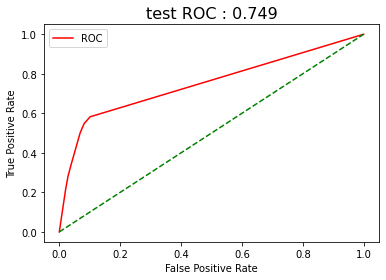

f1 score:  0.37113543091655266 

auc score:  0.7489050704840062 

test acc score:  0.9082226753080166 

[[1412324  103869]
 [  43235   43408]]


In [ ]:
plot_roc_curve(y_test,stack_pred,stack_prob)